In [1]:
!pip install geopandas osmnx==1.1.1 matplotlib==3.3

# Load data from OSM

In [2]:
import osmnx as ox
G = ox.graph_from_place('Sutherland Shire Council', network_type='drive')

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


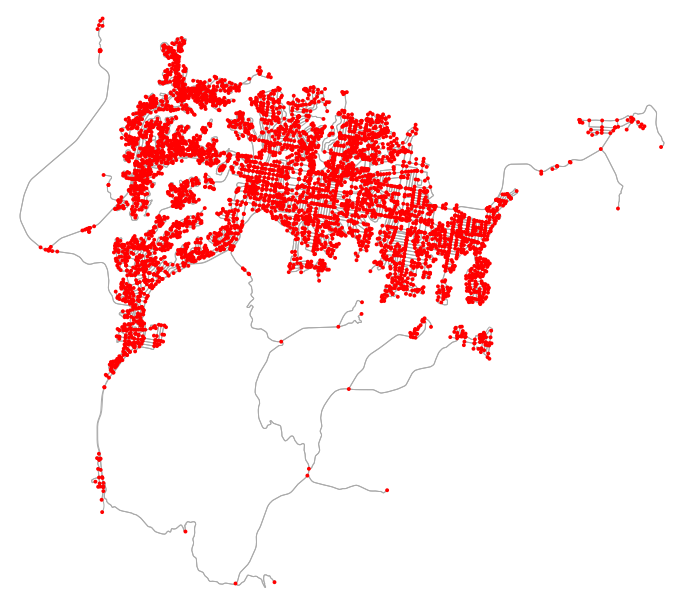

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(G, bgcolor="w", node_color="r", edge_color="#aaa", figsize=(12,12))

In [4]:
print("node count:", len(G.nodes()))
print("edge count:", len(G.edges()))

node count: 5510
edge count: 12308


In [5]:
# find nearest node
station_st_node_id = ox.distance.nearest_nodes(G, [151.014898], [-34.06714])[0]
station_st_node_id

268185063

In [6]:
# find node by ID and show its properties
G.nodes.get(station_st_node_id)
# --> {'street_count': 3, 'x': 151.0149055, 'y': -34.0671669}

{'y': -34.0671669, 'x': 151.0149055, 'street_count': 3}

In [7]:
# find its neighbouring nodes
list(G.neighbors(station_st_node_id))
# --> [1839271812, 668727077]

[1839271812, 668727077]

In [8]:
import json

# show edge attributes
for edge in G.out_edges(station_st_node_id, data=True):
    print("\n=== Edge ====")
    print("Source and target node ID:", edge[:2])
    edge_attributes = edge[2]
    # remove geometry object from output
    edge_attributes_wo_geometry = {i:edge_attributes[i] for i in edge_attributes if i!='geometry'}
    print("Edge attributes:", json.dumps(edge_attributes_wo_geometry, indent=4))


=== Edge ====
Source and target node ID: (268185063, 1839271812)
Edge attributes: {
    "osmid": 173099486,
    "name": "Station Street",
    "highway": "unclassified",
    "maxspeed": "50",
    "oneway": false,
    "length": 101.788
}

=== Edge ====
Source and target node ID: (268185063, 668727077)
Edge attributes: {
    "osmid": 356065478,
    "oneway": true,
    "lanes": "3",
    "ref": "A1",
    "name": "Railway Parade",
    "highway": "trunk",
    "maxspeed": "70",
    "length": 96.398
}


# Finding shortest route

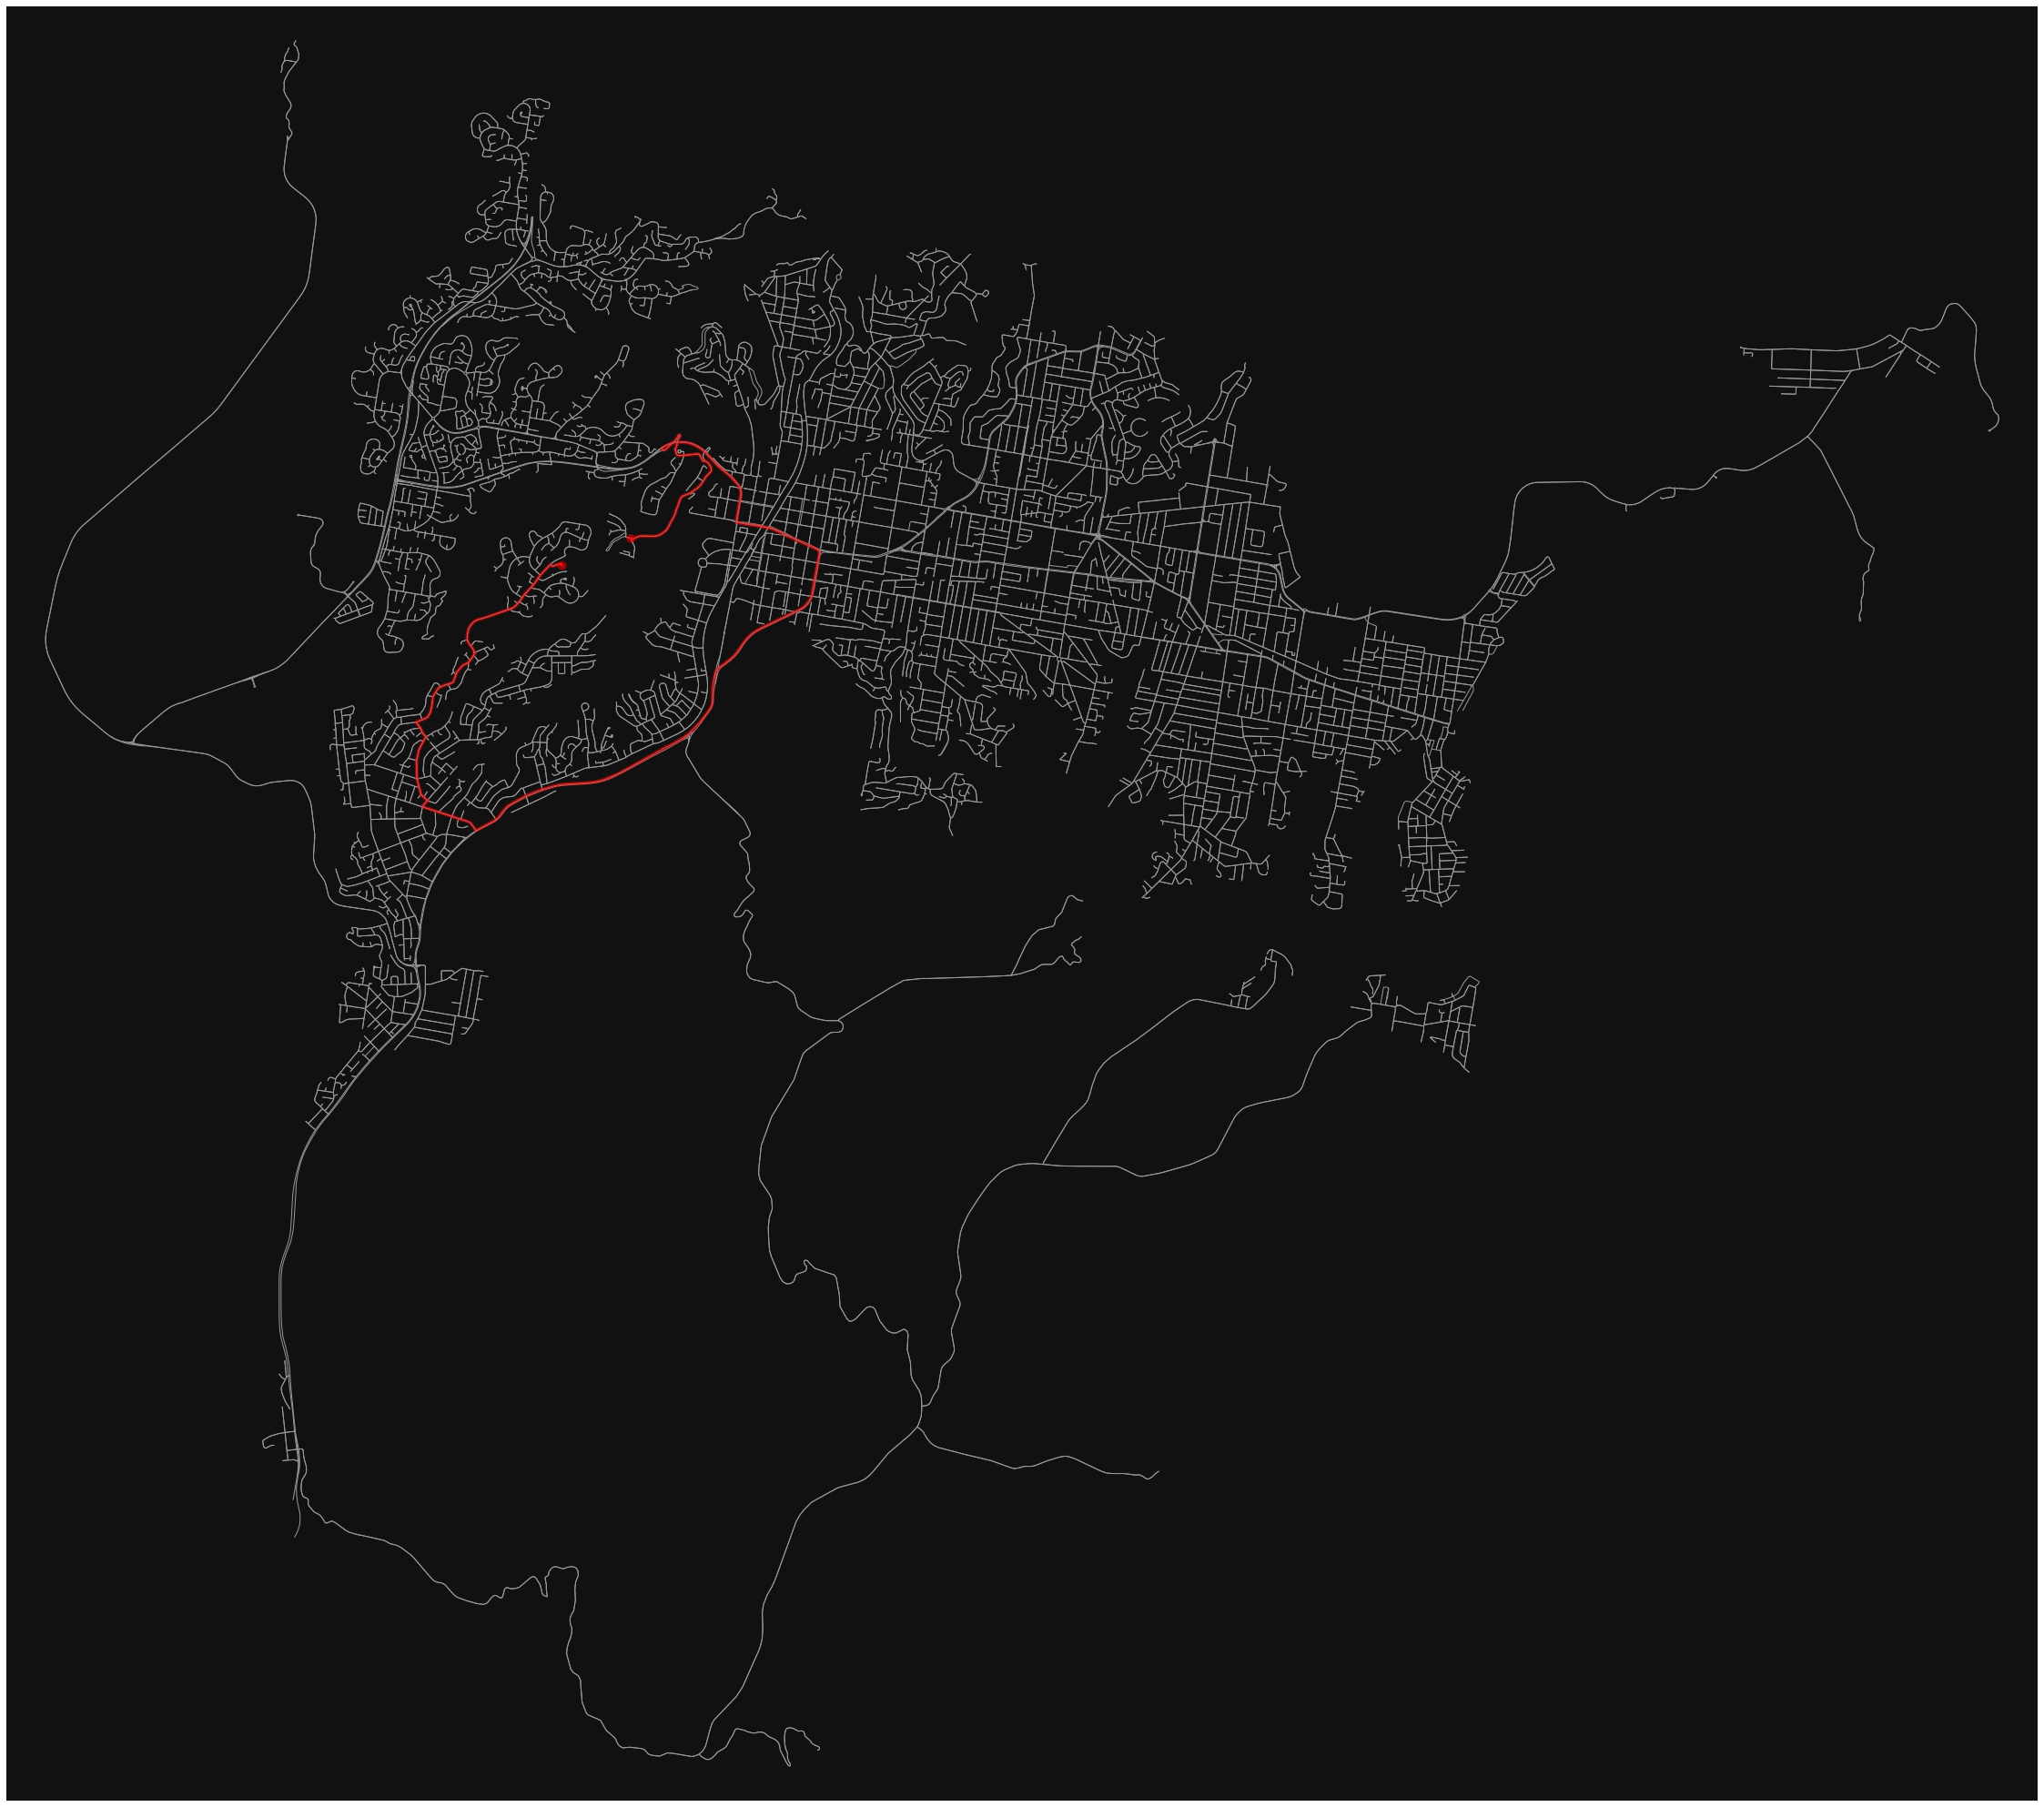

In [9]:
import geopandas as gpd
import networkx as nx

# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# convert string address into geographical coordinates
def geocode_address(address, crs=4326):
    geocode = gpd.tools.geocode(address, provider='nominatim', 
                user_agent="drive time demo").to_crs(crs)
    return (geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x)

# get origin and destination coordinates
origin_point = geocode_address("Whimbrel Place, Woronora Heights, NSW")
destination_point = geocode_address("Prince Edward Park, Woronora, NSW")

# get closes graph nodes to origin and destination
orig_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0])
destination_node = ox.distance.nearest_nodes(G, 
    destination_point[1], destination_point[0])

# find shortest path based on travel time
route = nx.shortest_path(G, orig_node, destination_node, weight='travel_time')

fig, ax = ox.plot_graph_route(G, route, node_size=0, figsize=(40,40))

In [10]:
edge_lengths = ox.utils_graph.get_route_edge_attributes(
    G, route, 'length') 
total_route_length = sum(edge_lengths)
print("Total route length in km:", total_route_length/1000)

edge_travel_time = ox.utils_graph.get_route_edge_attributes(
    G, route, 'travel_time') 
route_travel_time = sum(edge_travel_time)
print("Travel time in minutes:", route_travel_time/60)

Total route length in km: 16.786728
Travel time in minutes: 16.895000000000003


# Save graph

In [11]:
ox.save_graphml(G, 'sutherland_drive.graphml')

# Generate node & edges graph

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def show_directions(origin_node_id):
  map_limit_x = 0.0025
  map_limit_y = 0.0015
  fig = plt.figure(figsize=(8,8))
  ax = plt.axes()
  origin_node = G.nodes.get(origin_node_id)

  G2 = nx.generators.ego_graph(G, origin_node_id, radius=6)
  gdf_nodes, gdf_edges = ox.graph_to_gdfs(G2)

  gdf_edges.plot(ax=ax, color="#aaa")
  gdf_nodes.plot(ax=ax, color="r", zorder=12)
  ax.set_xlim(origin_node["x"]-map_limit_x, origin_node["x"]+map_limit_x)
  ax.set_ylim(origin_node["y"]-map_limit_y, origin_node["y"]+map_limit_y)

  for node_id in list(G.neighbors(origin_node_id)) + [origin_node_id]:
    node = G.nodes.get(node_id)
    txt = ax.annotate(text=f"{node_id}", xy=(node["x"]+0.0001,node["y"]+0.0001),
                  horizontalalignment='left', fontsize=10, wrap=True, color='k', zorder=11)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    if node_id != origin_node_id:
      ax.quiver(origin_node["x"], origin_node["y"], node["x"]-origin_node["x"], node["y"]-origin_node["y"], angles='xy', scale_units='xy', scale=1, zorder=10)

  ax.set_axis_on()

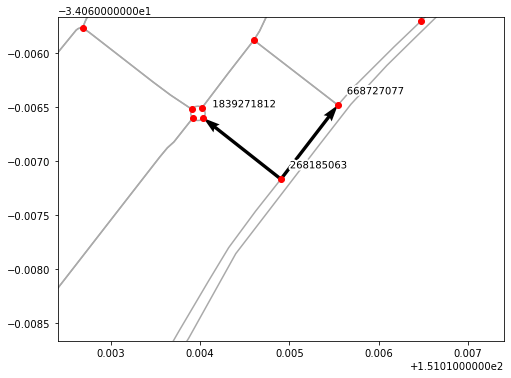

In [13]:
show_directions(station_st_node_id)